In [1]:
import pandas as pd
import numpy as np
import os
import lightgbm as lgb

In [2]:
path = "..\m5_forecasting"

calendar = pd.read_csv(os.path.join(path, "calendar.csv"))
selling_prices = pd.read_csv(os.path.join(path, "sell_prices.csv"))
sample_submission = pd.read_csv(os.path.join(path, "sample_submission.csv"))
sales = pd.read_csv(os.path.join(path, "sales_train_validation.csv"))

In [3]:
from sklearn.preprocessing import OrdinalEncoder

def prep_calendar(df):
    df = df.drop(["date", "weekday", "event_type_1", "event_type_2"], axis=1)
    df = df.assign(d = df.d.str[2:].astype(int))
    to_ordinal = ["event_name_1", "event_name_2"] 
    df[to_ordinal] = df[to_ordinal].fillna("1")
    df[to_ordinal] = OrdinalEncoder(dtype="int").fit_transform(df[to_ordinal]) + 1
    to_int8 = ["wday", "month", "snap_CA", "snap_TX", "snap_WI"] + to_ordinal
    df[to_int8] = df[to_int8].astype("int8")
    
    return df

calendar = prep_calendar(calendar)
calendar.head()

,wm_yr_wk,wday,month,year,d,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI
0,11101,1,1,2011,1,1,1,0,0,0
1,11101,2,1,2011,2,1,1,0,0,0
2,11101,3,1,2011,3,1,1,0,0,0
3,11101,4,2,2011,4,1,1,1,1,0
4,11101,5,2,2011,5,1,1,1,0,1


In [4]:
from sklearn.model_selection import train_test_split

LAGS = [7, 30]
WINDOWS = [7, 30]
FIRST = 1914
LENGTH = 28

def demand_features(df):
    """ Derive features from sales data and remove rows with missing values """
    
    for lag in LAGS:
        df[f'lag_t{lag}'] = df.groupby('id')['demand'].transform(lambda x: x.shift(lag)).astype("float32")
        for w in WINDOWS:
            df[f'rolling_mean_lag{lag}_w{w}'] = df.groupby('id')[f'lag_t{lag}'].transform(lambda x: x.rolling(w).mean()).astype("float32")
        
    return df

def demand_features_eval(df):
    """ Same as demand_features but for the step-by-step evaluation """
    out = df.groupby('id', sort=False).last()
    for lag in LAGS:
        out[f'lag_t{lag}'] = df.groupby('id', sort=False)['demand'].nth(-lag-1).astype("float32")
        for w in WINDOWS:
            out[f'rolling_mean_lag{lag}_w{w}'] = df.groupby('id', sort=False)['demand'].nth(list(range(-lag-w, -lag))).groupby('id', sort=False).mean().astype("float32")
    
    return out.reset_index()

def prep_data(df, drop_d=1000):
    """ Prepare model data sets """
    
    # Kick out old dates
    df = df.drop(["d_" + str(i+1) for i in range(drop_d)], axis=1)

    # Reshape to long
    df = df.assign(id=df.id.str.replace("_validation", ""))
    df = df.reindex(columns=df.columns.tolist() + ["d_" + str(FIRST + i) for i in range(2 * LENGTH)])
    df = df.melt(id_vars=["id", "item_id", "store_id", "state_id", "dept_id", "cat_id"], var_name='d', value_name='demand')
    df = df.assign(d=df.d.str[2:].astype("int64"),
                   demand=df.demand.astype("float32"))
    
    # Add demand features
    df = demand_features(df)
    
    # Remove rows with NAs
    df = df[df.d > (drop_d + max(LAGS) + max(WINDOWS))]
 
    # Join calendar & prices
    df = df.merge(calendar, how="left", on="d")
    df = df.merge(selling_prices, how="left", on=["store_id", "item_id", "wm_yr_wk"])
    df = df.drop(["wm_yr_wk"], axis=1)
    
    # Ordinal encoding of remaining categorical fields
    for v in ["item_id", "store_id", "state_id", "dept_id", "cat_id"]:
        df[v] = OrdinalEncoder(dtype="int").fit_transform(df[[v]]).astype("int16") + 1
    
    # Determine list of covariables
    x = list(set(df.columns) - {'id', 'd', 'demand'})
            
    # Split into test, valid, train
    test = df[df.d >= FIRST - max(LAGS) - max(WINDOWS)]
    df = df[df.d < FIRST]

    xtrain, xvalid, ytrain, yvalid = train_test_split(df[x], df["demand"], test_size=0.1, shuffle=True, random_state=54)
    train = lgb.Dataset(xtrain, label = ytrain)
    valid = lgb.Dataset(xvalid, label = yvalid)

    return train, valid, test, x

def fit_model(train, valid):
    """ Fit LightGBM model """
     
    params = {
        'metric': 'rmse',
        'objective': 'poisson',
        'seed': 200,
        'force_row_wise' : True,
        'learning_rate' : 0.085,
        'lambda': 0.1,
        'num_leaves': 63,
        'sub_row' : 0.75,
        'bagging_freq' : 1,
        'colsample_bytree': 0.75
    }

    fit = lgb.train(params, 
                    train, 
                    num_boost_round = 2000, 
                    valid_sets = [valid], 
                    early_stopping_rounds = 200,
                    verbose_eval = 100)
    
    lgb.plot_importance(fit, importance_type="gain", precision=0, height=0.5, figsize=(6, 10));
    
    return fit

def pred_to_csv(fit, test, x, cols=sample_submission.columns, file="submission.csv"):
    """ Calculate predictions and append to submission csv """
    
    # Recursive prediction
    for i, day in enumerate(np.arange(FIRST, FIRST + LENGTH)):
        test_day = demand_features_eval(test[(test.d <= day) & (test.d >= day - max(LAGS) - max(WINDOWS))])
        test.loc[test.d == day, "demand"] = fit.predict(test_day[x]) * (1.025 + 0.01 * (day > 1928)) # https://www.kaggle.com/kyakovlev/m5-dark-magic
    
    # Prepare for reshaping
    test = test.assign(id=test.id + "_" + np.where(test.d < FIRST + LENGTH, "validation", "evaluation"),
                       F="F" + (test.d - FIRST + 1 - LENGTH * (test.d >= FIRST + LENGTH)).astype("str"))
    
    # Reshape
    submission = test.pivot(index="id", columns="F", values="demand").reset_index()[cols].fillna(1)
    
    # Export
    submission.to_csv(file, index=False)
    
    return True

In [5]:
train, valid, test, x = prep_data(sales, 1000)
fit = fit_model(train, valid)
pred_to_csv(fit, test, x)

Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 2.20419
[200]	valid_0's rmse: 2.16778
[300]	valid_0's rmse: 2.14383
[400]	valid_0's rmse: 2.13063
[500]	valid_0's rmse: 2.12123
[600]	valid_0's rmse: 2.11233
[700]	valid_0's rmse: 2.10776
[800]	valid_0's rmse: 2.10325
[900]	valid_0's rmse: 2.09843
[1000]	valid_0's rmse: 2.09444
[1100]	valid_0's rmse: 2.09107
[1200]	valid_0's rmse: 2.08733
[1300]	valid_0's rmse: 2.08463
[1400]	valid_0's rmse: 2.08189
[1500]	valid_0's rmse: 2.08044
[1600]	valid_0's rmse: 2.07873
[1700]	valid_0's rmse: 2.07793
[1800]	valid_0's rmse: 2.07672
[1900]	valid_0's rmse: 2.07497
[2000]	valid_0's rmse: 2.07356
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 2.07356


True

In [ ]:
# with lags and windows set to [7,28]
# [2000]	valid_0's rmse: 2.10564
# Did not meet early stopping. Best iteration is:
# [2000]	valid_0's rmse: 2.10564

In [ ]:
# with lags and windows set to [7,30]
# [2000]	valid_0's rmse: 2.07356
# Did not meet early stopping. Best iteration is:
# [2000]	valid_0's rmse: 2.07356

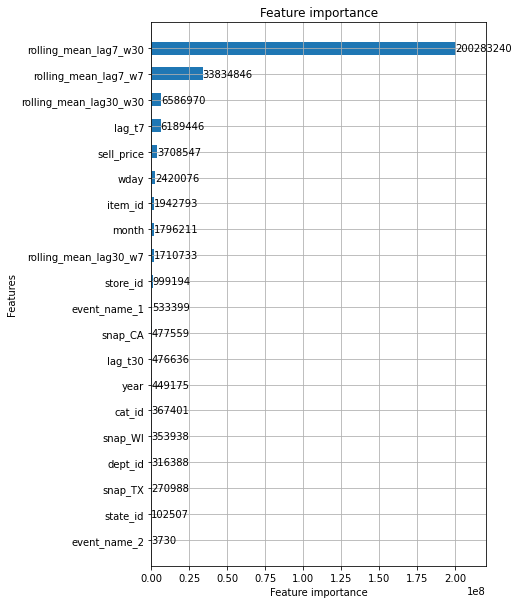

In [6]:
lgb.plot_importance(fit, importance_type="gain", precision=0, height=0.5, figsize=(6, 10))